In [11]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_device(device)
else:
    device = torch.device("cpu")

torch.set_default_dtype(torch.float64)

print(f"Using device: {device}")

Using device: cuda


In [14]:
from utils import *

obs, dt, gdf = get_taxi_data(200)
obs = obs.to(device)

# Define the grid size
grid_size = 40

# Create evenly spaced values between -1 and 1
x_edges = torch.linspace(-1, 1, grid_size + 1, dtype=torch.float64)
y_edges = torch.linspace(-1, 1, grid_size + 1, dtype=torch.float64)

# Initialize the count tensor
counts = torch.zeros((grid_size, grid_size), dtype=torch.float64)

# Count the number of points in each bin
for point in obs:
    x_idx = torch.searchsorted(x_edges, point[0], right=True) - 1
    y_idx = torch.searchsorted(y_edges, point[1], right=True) - 1
    if 0 <= x_idx < grid_size and 0 <= y_idx < grid_size:
        counts[x_idx, y_idx] += 1

counts = counts.view(-1)
x = get_grid(grid_size, -1, -1, 1, 1)
area_per_grid = 4.0 / (grid_size ** 2)

In [16]:
import numpy as np
import scipy
from stpy.kernels import KernelFunction
from tqdm import tqdm

def sqrt(matrix: torch.Tensor) -> torch.Tensor:
    return torch.from_numpy(
        np.real(
            scipy.linalg.sqrtm(
                matrix.cpu().numpy() + 1e-5
            )
        )
    ).to(device)

class LogCoxProcess():
    def __init__(self, kernel_object: KernelFunction):
        self.kernel = kernel_object.kernel

    def get_intensity_MAP(self):
        pass # apparently similar to gamma_MAP but with $\nabla - (1, \ldots, 1)$

    def get_gamma_MAP(self, n, x, a, lr=0.01, max_it=10000, eps=1e-6):
        mean = 0
        cov_Y = self.kernel(x, x)
        Q = sqrt(cov_Y)
        self.Q = Q

        def f(arg):
            y = arg @ Q + mean
            return (-0.5) * arg.pow(2).sum() + (y * n - torch.exp(y) * a).sum()

        gamma = torch.zeros(len(x), dtype=torch.float64, requires_grad=True)
        optimizer = torch.optim.SGD([gamma], lr=lr)

        # Use tqdm to show progress
        prev_loss = float('inf')
        for _ in tqdm(range(max_it), desc="Optimizing gamma"):
            optimizer.zero_grad()
            loss = -f(gamma)  # we minimize -f because we want to maximize f
            if loss.item() > prev_loss:
                print("Warning: Loss did not decrease")
            prev_loss = loss.item()
            loss.backward()
            # If gradient is smaller than eps, return
            if torch.norm(gamma.grad) < eps:
                print("Solved to eps")
                break
            optimizer.step()

        assert(f(gamma) > 
               f(torch.distributions.MultivariateNormal(loc=gamma, covariance_matrix=torch.eye(len(gamma))*50).sample()))

        return gamma.detach()

    def sample_mala(self, n, x, a, h, num_steps, burn_in_steps, initial_gamma = None):
        # param n is 1d tensor with the counts of points in the cells
        # param x is the discretization of the area we're interested in
        # param a is either a 2d tensor with the areas of the discretization
        # or a float that gives all areas
        # step size h
        # Need: Current state gamma (MAP?), chosen step size h
        gamma = self.get_MAP() if initial_gamma is None else initial_gamma
        mean = 0 # prior mean I think?
        cov_Y = self.kernel(x, x)
        Q = self.Q
        accept_prob_sum = 0

        for i in range(num_steps):
            # The log posterior over gamma given the data
            def log_f(arg):
                y = arg @ Q + mean
                return (-0.5) * arg.pow(2).sum() + (y * n - torch.exp(y) * a).sum()

            # Gradient of the energy
            def grad(arg):
                y = arg @ Q + mean
                return - arg + (n - torch.exp(y) * a) @ Q.T

            # mean of the proposal distribution, named \xi in paper
            def r_mean_given_arg(arg):
                return arg + (h/2.0) * grad(arg)

            # Proposal
            proposal = torch.distributions.MultivariateNormal(
                loc=r_mean_given_arg(gamma),
                covariance_matrix= h*torch.eye(len(gamma), dtype=torch.float64)
            ).sample()

            accept_prob = torch.exp(
                log_f(proposal)
                - (gamma - r_mean_given_arg(proposal)).pow(2).sum() / (2 * h)
            ) / (
                torch.exp(
                    log_f(gamma)
                    - (proposal - r_mean_given_arg(gamma)).pow(2).sum() / (2 * h)
                )
            )

            if np.random.rand() < accept_prob:
                gamma = proposal

            accept_prob_sum += min(accept_prob.item(), 1.0)

            if i > burn_in_steps:
                yield torch.exp(gamma @ Q + mean)

        mean_accept_prob = accept_prob_sum / num_steps
        print(mean_accept_prob)


kernel_object = KernelFunction(kernel_name="squared_exponential", gamma=0.12, d=2)
process = LogCoxProcess(kernel_object)
gamma_map = process.get_gamma_MAP(counts, x, torch.tensor(2.0/900.0), lr=0.005)
not_y_map = gamma_map @ process.Q
samples = [s for s in process.sample_mala(counts, x, torch.tensor(4.0 / 900.0), 0.06, 1300, 400, gamma_map)]

Optimizing gamma:  26%|██▌       | 2598/10000 [00:04<00:14, 514.26it/s]

Optimizing gamma:  27%|██▋       | 2702/10000 [00:04<00:14, 510.17it/s]

Optimizing gamma:  28%|██▊       | 2806/10000 [00:04<00:14, 505.94it/s]

Optimizing gamma:  29%|██▊       | 2851/10000 [00:04<00:12, 570.49it/s]


Solved to eps
nan


In [18]:
# make a tensor with extra dimension out of a list of tensors
samples = torch.stack(samples)


In [19]:
samples.shape

torch.Size([899, 1600])

In [20]:
mean_values = samples.mean(0)
mean_values.shape

torch.Size([1600])

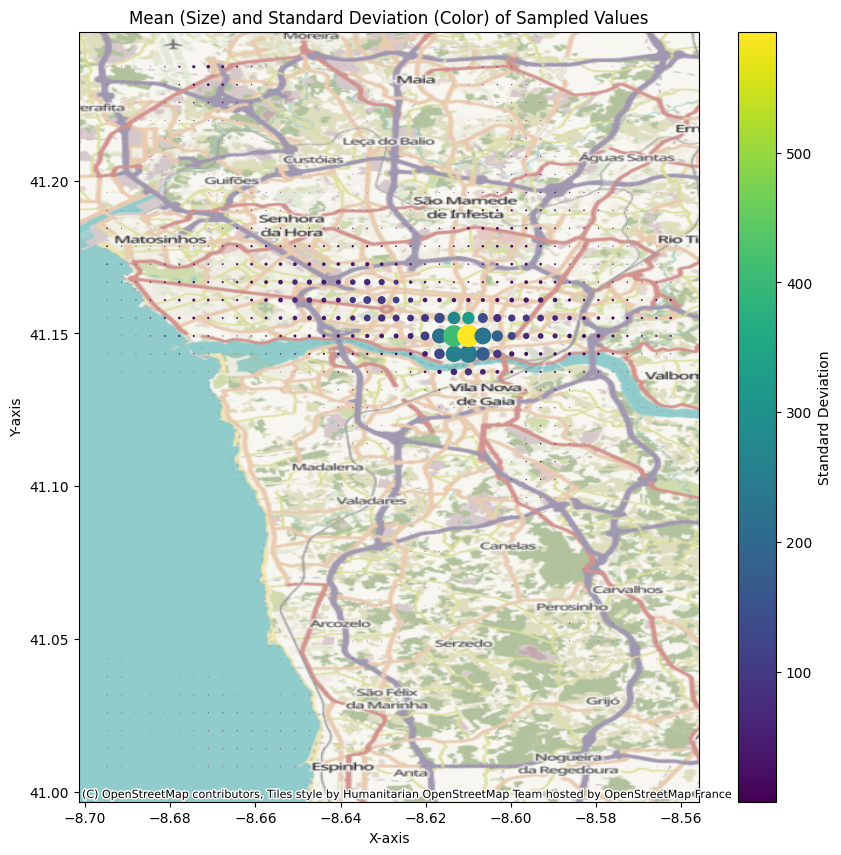

In [21]:
import contextily as ctx
import matplotlib.pyplot as plt


left, down, right, up = gdf.total_bounds
xtest_orig = get_grid(grid_size, left, down, right, up)

# Prepare coordinates for plotting
xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

# Calculate mean and standard deviation across samples at each point
mean_values = torch.mean(samples, dim=0)
std_values = torch.std(samples, dim=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Define a scaling factor for the sizes based on mean values
scale_factor = 0.1  # Adjust this factor as needed for visual clarity

# Scatter plot with mean values as size and std as color using viridis colormap
scatter = ax.scatter(
    xx.cpu(),
    yy.cpu(),
    c=std_values.cpu(),
    cmap="viridis",
    s=mean_values.cpu() * scale_factor,  # Scale point size by mean values
    alpha=1.0,
    edgecolor="face",
    linewidth=0.0,
    marker="o",
)

ctx.add_basemap(ax, crs=gdf.crs.to_string())

# Color bar for the standard deviation (variance)
cbar = fig.colorbar(scatter, ax=ax, label="Standard Deviation")

# Labeling
ax.set_title("Mean (Size) and Standard Deviation (Color) of Sampled Values")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")

plt.show()

In [22]:
print(
    f"Mean in [{torch.min(mean_values)}, {torch.max(mean_values)}] and std in"
    f" [{torch.min(std_values)}, {torch.max(std_values)}]"
)

Mean in [0.06994985299993187, 2569.1340165546153] and std in [0.02496832358075976, 593.1229798718309]


In [23]:
expected_num_points = torch.tensor(4.0 / 900.0) * mean_values.sum(0)
expected_num_points

tensor(158.0224, device='cuda:0')